In [44]:

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
from scipy.stats import pareto, gamma
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import numpy as np

from datetime import date

filename = "test_dataset.csv"

# read the data
data = pd.read_csv(filename, skipinitialspace=True)
data.columns = data.columns.str.strip()

# Display first few rows to check structure
print(data.head())
print(data.columns)

                 Track ID              Track Name  \
0  1TCRCDezEMaQ60yIO8Me6F               Dana dana   
1  0tgVpDi06FyKpA1z0VMD4v                 Perfect   
2  7wKUqlOL9OES7gwPdgUcQl   رايحين نسهر - بام بام   
3  1bxP4M9ICllcg7mel8kH89                   Reine   
4  0pwYLVXVknPSGUQb39cePC  As Long As You Love Me   

                        Album Name          Artist Name(s) Release Date  \
0  L'anthologie du Raï (50 titres)              Cheb Rayan   2016-01-29   
1                       ÷ (Deluxe)              Ed Sheeran   2017-03-03   
2    رايحين نسهر - بام بام - سينجل         Mohamed Ramadan   2019-01-01   
3                    Gentleman 2.0                   Dadju   2017-11-24   
4         Believe (Deluxe Edition)  Justin Bieber,Big Sean   2012-06-15   

   Duration (ms)  Popularity                   Added By              Added At  \
0         232333           0  myo20ysxpfrjcs3hesgkcs93f  2024-10-30T00:20:04Z   
1         263400          85  myo20ysxpfrjcs3hesgkcs93f  2024-10-29T

In [45]:
features = data[['Tempo', 'Valence',  'Danceability', 'Energy', 'Key']].dropna()


In [46]:

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


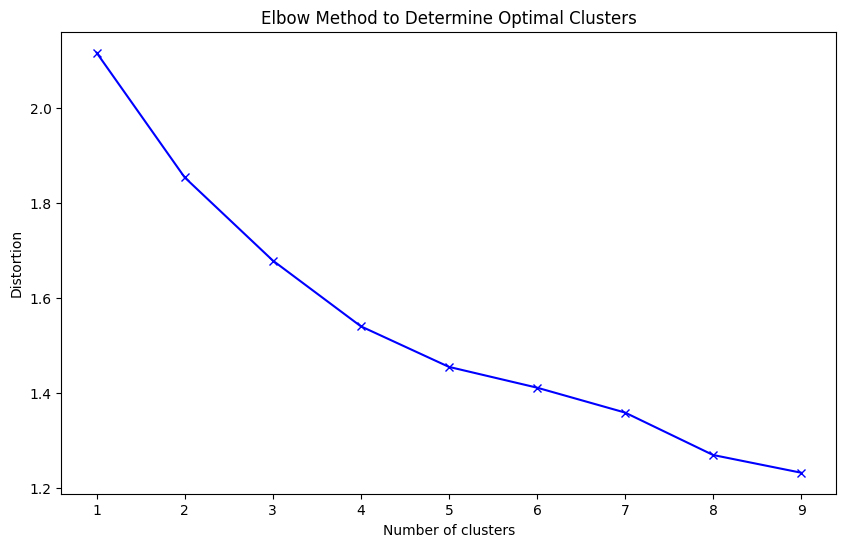

In [47]:
# Elbow method to find optimal number of clusters
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    distortions.append(sum(np.min(cdist(features_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)) / features_scaled.shape[0])

# Plotting the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()


In [48]:
# Clustering with the chosen number of clusters (adjust 'n_clusters' based on elbow method)
optimal_clusters = 9  # Replace with your elbow result
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_scaled)

# Inspect the first few rows with cluster labels
print(data[['Track Name', 'Artist Name(s)', 'Tempo', 'Valence', 'Danceability', 'Energy', 'Key', 'Cluster']].head())


               Track Name          Artist Name(s)    Tempo  Valence  \
0               Dana dana              Cheb Rayan  105.807    0.913   
1                 Perfect              Ed Sheeran   95.050    0.168   
2   رايحين نسهر - بام بام         Mohamed Ramadan  160.024    0.929   
3                   Reine                   Dadju   98.174    0.704   
4  As Long As You Love Me  Justin Bieber,Big Sean  139.691    0.613   

   Danceability  Energy  Key  Cluster  
0         0.741   0.835    0        1  
1         0.599   0.448    8        3  
2         0.720   0.997    2        6  
3         0.399   0.395    2        3  
4         0.571   0.873    0        6  


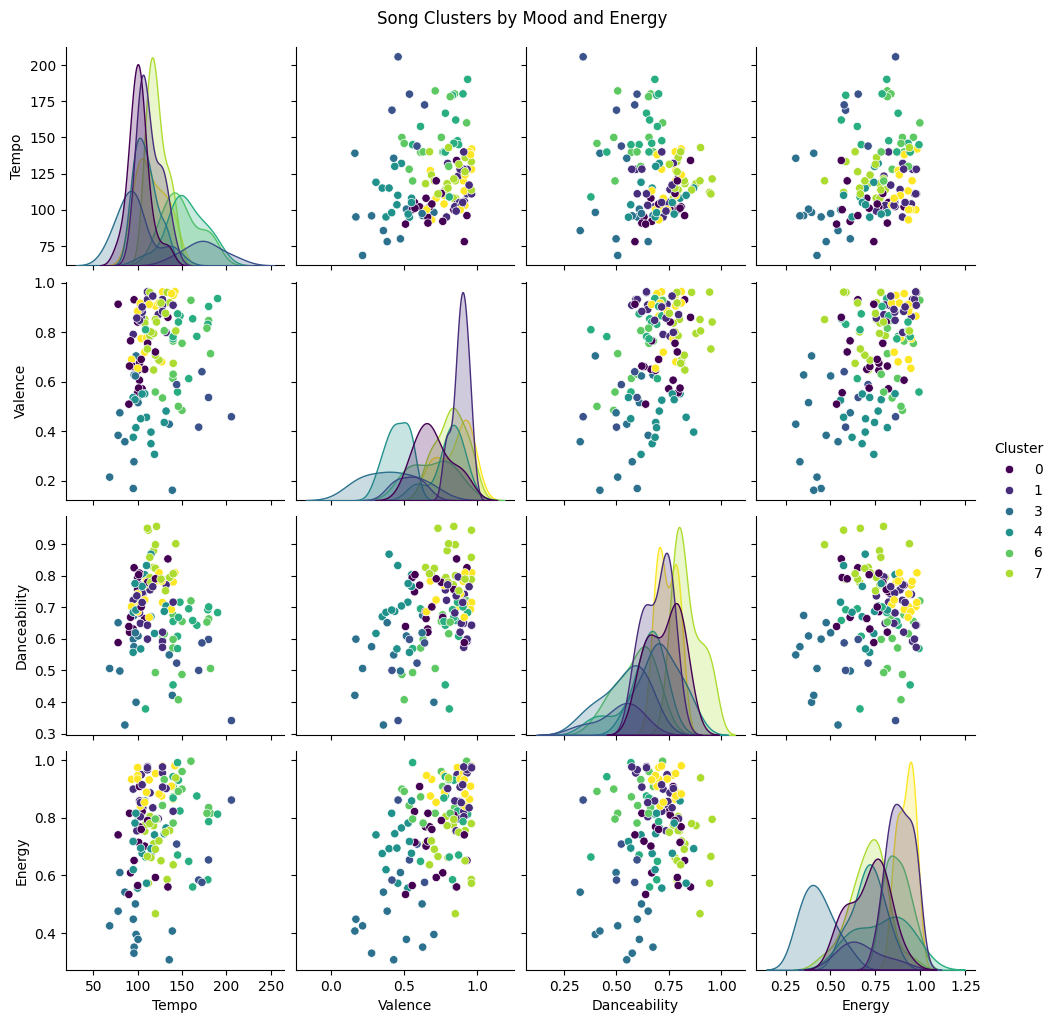

In [49]:
# Pairplot to visualize clusters
sns.pairplot(data[['Tempo', 'Valence', 'Danceability', 'Energy', 'Cluster']], hue='Cluster', palette='viridis')
plt.suptitle("Song Clusters by Mood and Energy", y=1.02)
plt.show()


In [50]:
def suggest_next_song(current_track_id):
    # Find current track's cluster
    current_song = data[data['Track ID'] == current_track_id]
    if current_song.empty:
        return "Track ID not found."
    
    cluster = current_song['Cluster'].values[0]
    # Find other songs in the same cluster, excluding the current song
    similar_songs = data[(data['Cluster'] == cluster) & (data['Track ID'] != current_track_id)]
    
    # Sort by tempo, valence, or any metric you choose for smooth transitions
    similar_songs = similar_songs.sort_values(by='Tempo', ascending=False)
    
    # Return a suggestion
    return similar_songs[['Track Name', 'Artist Name(s)', 'Tempo', 'Valence', 'Danceability']].head(5)

# Example of getting next song suggestion
suggested_songs = suggest_next_song("1pKYYY0dkg23sQQXi0Q5zN")
print("Suggested next songs for smooth transition:")
print(suggested_songs)


Suggested next songs for smooth transition:
               Track Name                                     Artist Name(s)  \
117       Bande organisée  Kofs,Soso Maness,Elams,Jul,SCH,Naps,Solda,Houa...   
116           La kiffance                                               Naps   
32   Allah Aleik Ya Seedy                                        Ehab Tawfik   
31             Wala Wahed                                              Hakim   
112         On va s'aimer                                   Gilbert Montagné   

       Tempo  Valence  Danceability  
117  142.948    0.805         0.901  
116  140.053    0.674         0.806  
32   136.011    0.919         0.794  
31   133.215    0.961         0.788  
112  131.394    0.876         0.752  


In [52]:
# Assuming `data` is already clustered and cleaned

def generate_playlist(data):
    # Make a copy to prevent modifying the original DataFrame
    playlist_data = data.copy()

    # List to hold the playlist order (track IDs)
    playlist_order = []

    # Select the first song (you could pick any starting song here; we'll use the first row)
    current_song = playlist_data.iloc[0]
    playlist_order.append(current_song['Track ID'])

    # Loop until we've added all songs to the playlist
    while len(playlist_order) < len(playlist_data):
        # Get the current song's cluster and filter for songs in the same cluster
        current_cluster = current_song['Cluster']
        potential_songs = playlist_data[(playlist_data['Cluster'] == current_cluster) & (~playlist_data['Track ID'].isin(playlist_order))]

        # If no songs are left in the cluster, switch to a new cluster
        if potential_songs.empty:
            potential_songs = playlist_data[~playlist_data['Track ID'].isin(playlist_order)]

        # Sort remaining songs by proximity to the current song's tempo or other feature (e.g., Valence)
        # Here we prioritize smooth transitions in `Tempo` and `Valence`
        potential_songs = potential_songs.copy()
        potential_songs.loc[:, 'distance'] = (potential_songs['Tempo'] - current_song['Tempo']).abs() + (potential_songs['Valence'] - current_song['Valence']).abs()
        next_song = potential_songs.sort_values(by='distance').iloc[0]
        
        # Add the selected song to the playlist and update the current song
        playlist_order.append(next_song['Track ID'])
        current_song = next_song

    # Return playlist order (Track IDs)
    return playlist_order

# Generate the playlist order
playlist_order = generate_playlist(data)

# Output ordered playlist based on Track IDs
ordered_playlist = data.set_index('Track ID').loc[playlist_order]

# Save the ordered playlist to a CSV file
output_filename = "ordered_playlist.csv"
ordered_playlist.to_csv(output_filename, index=False)

print(f"Ordered playlist has been saved to '{output_filename}'.")

Ordered playlist has been saved to 'ordered_playlist.csv'.
